In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Charger les données
df = pd.read_csv('/content/drive/MyDrive/train.csv', encoding='latin-1')
print(df.columns)

# Sélectionner les colonnes intéressantes
colonnes = ['Order Date', 'Category', 'Sales']
df = df.loc[:, colonnes]


# Convertir la colonne 'Order Date' en type datetime avec le bon format
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

# Sélectionner un produit spécifique
produit_choisi = 'Technology'  # Remplacez par le nom réel du produit

# Filtrer les données pour le produit choisi
df_produit = df[df['Category'] == produit_choisi]

df.sort_values(by='Order Date', inplace=True)
# Agréger les données par 'Order Date' et 'Category'
df_aggregated = df_produit.groupby(['Order Date', 'Category']).sum().reset_index()

# Utiliser pivot pour réorganiser le dataframe
df_pivot = df_aggregated.pivot(index='Order Date', columns='Category', values='Sales')

#Fill any missing values
#df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill')


print(df)
print(df_pivot)

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales'],
      dtype='object')
     Order Date         Category    Sales
7980 2015-01-03  Office Supplies   16.448
741  2015-01-04  Office Supplies    3.540
740  2015-01-04  Office Supplies  272.736
739  2015-01-04  Office Supplies   11.784
1759 2015-01-05  Office Supplies   19.536
...         ...              ...      ...
1297 2018-12-30  Office Supplies   20.720
906  2018-12-30        Furniture  323.136
645  2018-12-30  Office Supplies  209.300
908  2018-12-30  Office Supplies   52.776
5091 2018-12-30  Office Supplies    3.024

[9800 rows x 3 columns]
Category    Technology
Order Date            
2015-01-06    1147.940
2015-01-09      31.200
2015-01-13     646.740
2015-01-15     149.950
2015-01-16     124.200
...                ...
2018-12-25 

In [ ]:
# Afficher les types des colonnes
print(df.dtypes)

Order Date    datetime64[ns]
Category              object
Sales                float64
dtype: object


In [ ]:
# Affichage de statistiques descriptives
print(df_pivot.describe())


             Sales
count  1826.000000
mean    503.918399
std     290.142419
min       0.186714
25%     250.651529
50%     505.678315
75%     761.662444
max     999.853828


In [ ]:
print(df_pivot.isnull().sum())

Category    0
Sales       0
dtype: int64


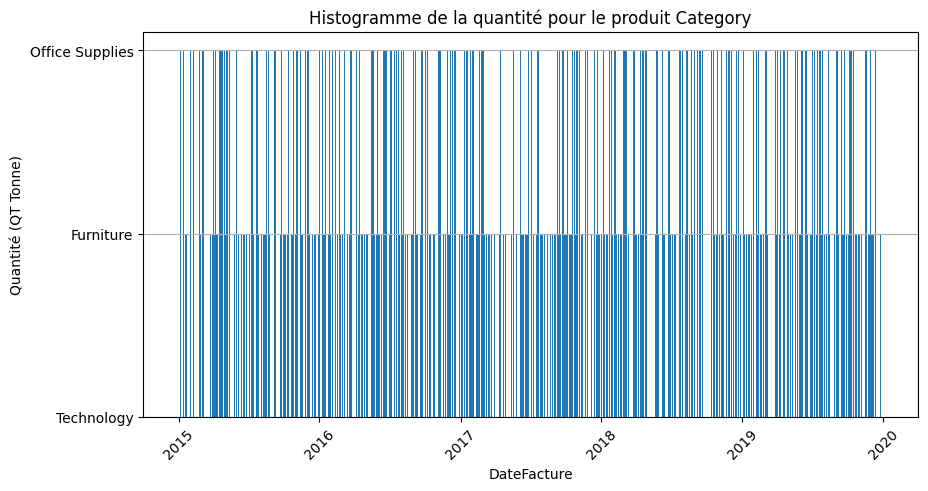

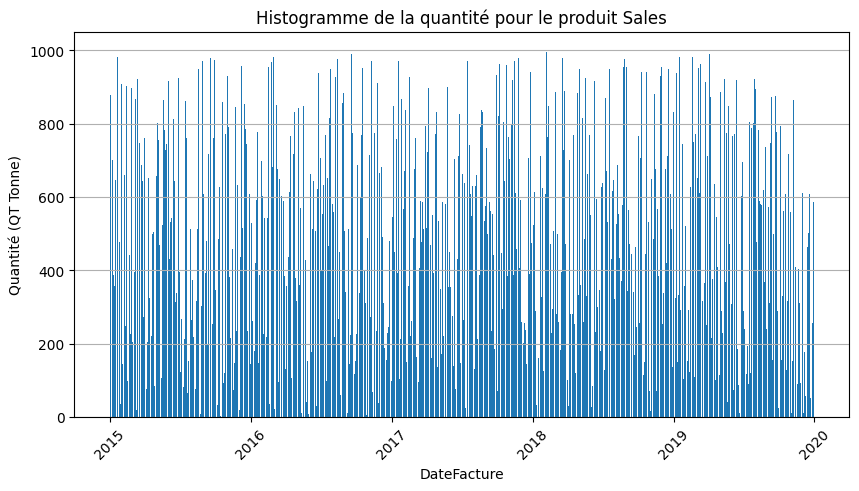

In [ ]:
# Créer des histogrammes pour chaque produit
for produit in df_pivot.columns:
    plt.figure(figsize=(10, 5))
    plt.bar(df_pivot.index, df_pivot[produit], width=0.8)
    plt.title(f'Histogramme de la quantité pour le produit {produit}')
    plt.xlabel('DateFacture')
    plt.ylabel('Quantité (QT Tonne)')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

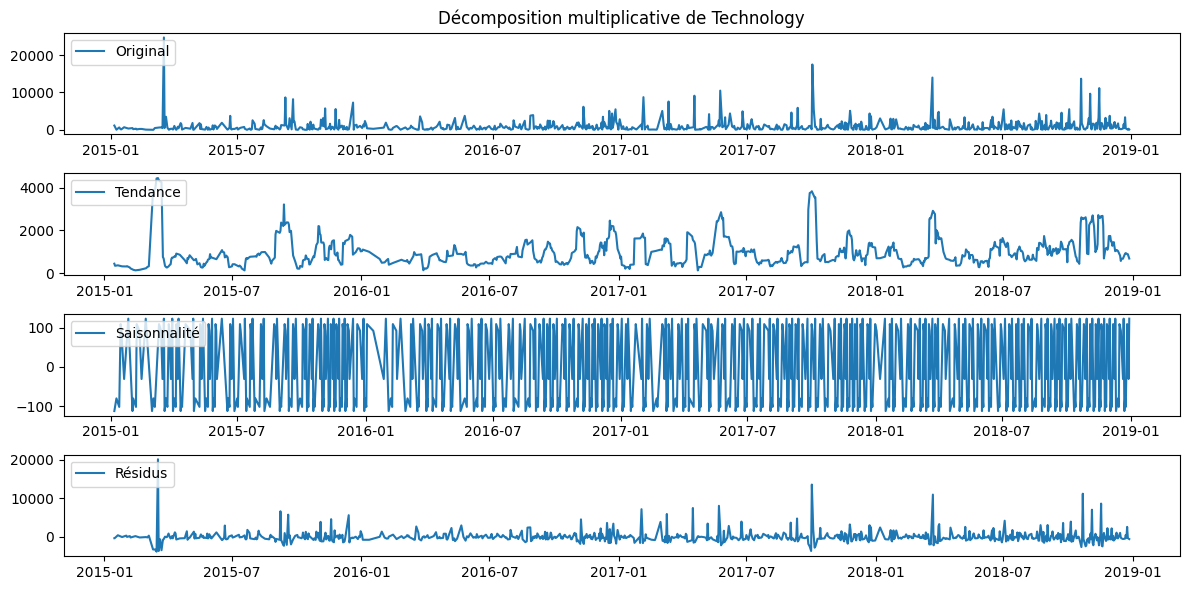

In [ ]:
for produit in df_pivot.columns:
    decomposition = seasonal_decompose(df_pivot[produit], model='additive', period=7)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Affichage des composantes de la décomposition
    plt.figure(figsize=(12, 6))
    plt.subplot(411)
    plt.plot(df_pivot[produit], label='Original')  # Correction ici
    plt.legend(loc='upper left')
    plt.title('Décomposition multiplicative de ' + produit)

    plt.subplot(412)
    plt.plot(trend, label='Tendance')
    plt.legend(loc='upper left')

    plt.subplot(413)
    plt.plot(seasonal,label='Saisonnalité')
    plt.legend(loc='upper left')

    plt.subplot(414)
    plt.plot(residual, label='Résidus')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
data = pd.DataFrame({produit: decomposition.trend.dropna() * decomposition.seasonal.dropna() for produit in df_pivot.columns})


# Normalisation des données
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_pivot.values.reshape(-1, 1))



In [ ]:
# Fonction pour créer des séquences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12
X, y = create_sequences(scaled_data, seq_length)




KeyError: 12

In [ ]:
# Filtrer les données d'entraînement (2015-2017) et de test (2018-2019)
train_data = data.loc['2015':'2017']
test_data = data.loc['2018']

# Normaliser les données de train et de test séparément
scaler_train = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler_train.fit_transform(train_data.values.reshape(-1, 1))
test_scaled = scaler_train.transform(test_data.values.reshape(-1, 1))

# Créer les séquences pour l'entraînement et le test
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Convertir en tensors PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_dim = 1
hidden_dim = 100
output_dim = 1
num_layers = 3


model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

NameError: name 'data' is not defined

MSE: 1522991.459022873
R2: -0.0035965600766036943


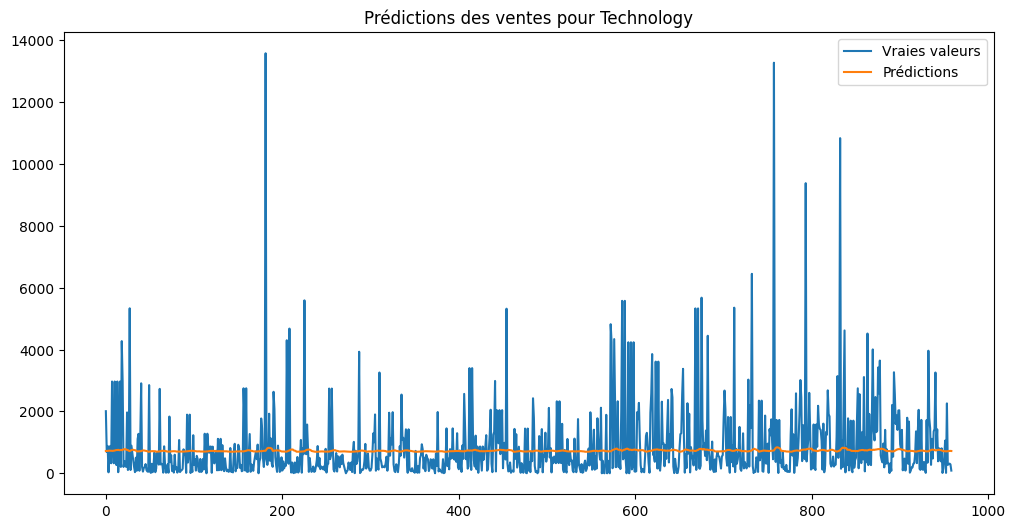

In [ ]:
model.eval()
predictions = model(X_test).detach().numpy()

# Inverser la transformation pour obtenir les valeurs réelles
predictions = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculer MSE et R2
mse = mean_squared_error(y_test_inverse, predictions)
r2 = r2_score(y_test_inverse, predictions)

print(f"MSE: {mse}")
print(f"R2: {r2}")

# Tracer les résultats
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Vraies valeurs')
plt.plot(predictions, label='Prédictions')
plt.title('Prédictions des ventes pour Technology')
plt.legend()
plt.show()


            Technology
2019-01-31  566.282870
2019-02-28  586.315433
2019-03-31  612.339757
2019-04-30  641.755031
2019-05-31  672.352568
2019-06-30  695.778017
2019-07-31  712.152885
2019-08-31  724.720673
2019-09-30  735.102120
2019-10-31  739.774354
2019-11-30  743.229123
2019-12-31  746.245001


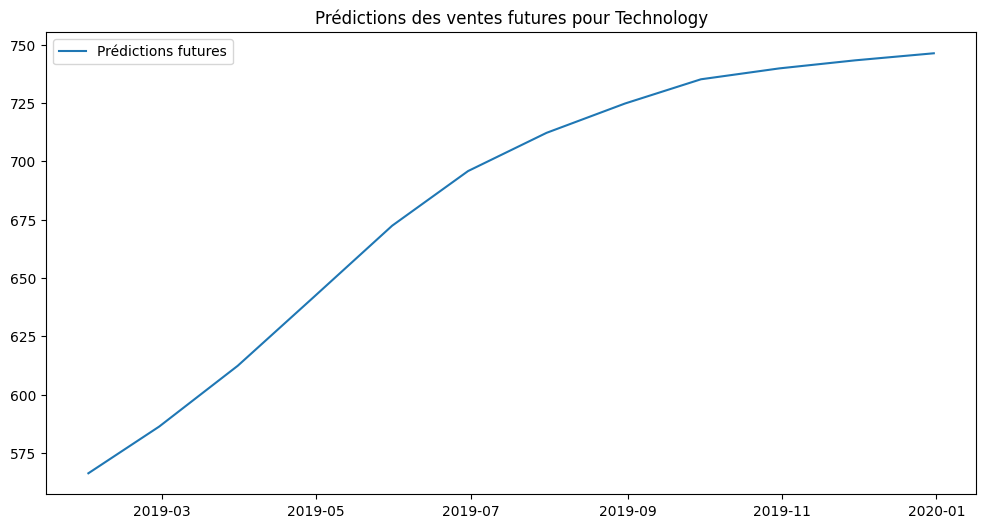

In [ ]:
future_seq = torch.tensor(train_scaled[-seq_length:].reshape(1, seq_length, 1), dtype=torch.float32)
future_steps = 12
future_predictions = []
model.eval()
for _ in range(future_steps):
    next_pred = model(future_seq)
    future_predictions.append(next_pred.detach().numpy()[0])
    future_seq = torch.cat((future_seq[:, 1:, :], next_pred.unsqueeze(1)), dim=1)

# Inverse transform the future predictions
future_predictions = scaler_train.inverse_transform(future_predictions)

# Convert future predictions to DataFrame
future_dates = pd.date_range(start=df_pivot.index[-1], periods=future_steps + 1, freq='M')[1:]
future_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Technology'])

# Afficher les prédictions futures sous forme de tableau
print(future_df)

# Tracer les prédictions futures
plt.figure(figsize=(12, 6))
plt.plot(future_df.index, future_df['Technology'], label='Prédictions futures')
plt.title('Prédictions des ventes futures pour Technology')
plt.legend()
plt.show()
